#Face Detection using a pre-trained GoogleNet model
This notebook describes the code done on order to fine-tune and train a pre-trained GoogleNet model to do a face detection task.

# Download and prepare the data

In [ ]:
#@title Dataset Downloader
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
def unzip(file, destination=None):
  if not destination or not os.path.isdir(destination):
    destination = os.path.dirname(file)
  print(file)
  print('unzipping to ',destination)
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(destination)
  zip_ref.close()
    
download_file_from_google_drive('1Snw-Idlz15qwIn3uFgzv0LOBa7tVw1UY', '/tmp/final_data.zip')
unzip('/tmp/final_data.zip', '/tmp')

base_dir = '/tmp/final_data/'
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

/tmp/final_data.zip
unzipping to  /tmp


Here we are making transformations on the images for data augmentation. Thus, the model will be more robust.

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

#Dataset creation

In [ ]:
import torchvision
from torch.utils.data import DataLoader
train_dataset = torchvision.datasets.ImageFolder(train_data_path, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_data_path, test_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 224, 224])


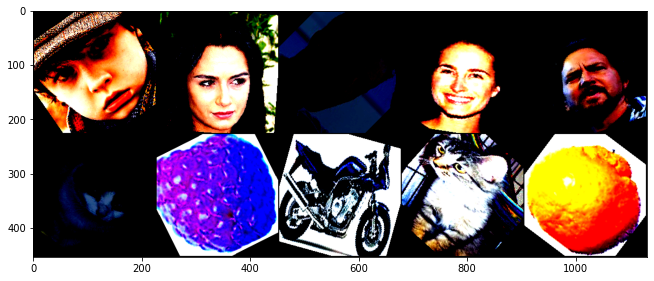

In [ ]:
#@title Show some augmented data
import numpy as np
import matplotlib.pyplot as plt

def show_image_dataset(dataset):
  loader = DataLoader(dataset, batch_size=10, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch
  print(images.size())
  grid = torchvision.utils.make_grid(images, nrow=5)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))

show_image_dataset(train_dataset)

In [ ]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model downloading and training

In [ ]:
#@title set device
def set_device() :
  if torch.cuda.is_available():
    dev='cuda:0'
  else:
    dev='cpu'
  return torch.device(dev)

In [ ]:
#@title Retrieve and set the model
import torch
from torch import nn
from torchsummary import summary
# retreiving googlenet model
googlenet = torchvision.models.googlenet(pretrained=True)

# freezing the params for fine tuning
for param in googlenet.parameters():
     param.requires_grad = False

num_ftrs = googlenet.fc.in_features

# creatin a new head for fine tuning
googlenet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

device = set_device()

googlenet = googlenet.to(device)

loss_ft = nn.BCELoss()
optimizer = torch.optim.Adam(googlenet.parameters())

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## Training and evaluate functions

In [ ]:
#@title Training function
def train_googlenet(model, tr_loader, tt_loader, criterion, optimizer, n_epochs):
  device = set_device()
  train_acc = []
  test_acc = []
  train_loss = []

  for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for data in tr_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      labels = labels.unsqueeze(1)
      labels = labels.to(torch.float)
      total += labels.size(0)

      optimizer.zero_grad()
      outputs = model(images)

      loss = criterion(outputs, labels)
      loss.backward()

      optimizer.step()

      # getting the current loss
      running_loss += loss.item()
      
      # counting the number of good guess
      cmp_labels = labels.reshape(labels.size(0))
      cmp_outputs = outputs.reshape(labels.size(0))
      running_correct += (cmp_labels == torch.round(cmp_outputs)).sum().item()

    epoch_loss = running_loss/len(tr_loader)
    epoch_accuracy = 100.0 * running_correct / total

    print(f"Train : epoch_acc: {epoch_accuracy} epoch_loss: {running_loss}")
    
    eval_acc = evaluate_model(model, tt_loader)
    train_acc.append(epoch_accuracy)
    test_acc.append(eval_acc)
    train_loss.append(running_loss)

  print('Finished')
  return model, train_acc, test_acc, train_loss

In [ ]:
#@title Evaluate function
def evaluate_model(model, tt_loader):
  model.eval()

  predicted_correctly = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in tt_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      labels = labels.unsqueeze(1)
      labels = labels.to(torch.float)
      total += labels.size(0)

      outputs = model(images)

      cmp_labels = labels.reshape(labels.size(0)) 
      cmp_outputs = outputs.reshape(labels.size(0)) 
      predicted_correctly += (cmp_labels == torch.round(cmp_outputs)).sum().item()

  epoch_acc = 100 * predicted_correctly / total
  print(f"Test: epoch_acc: {epoch_acc}")

  return epoch_acc


In [ ]:
model, train_accuracy, test_accuracy, train_loss = train_googlenet(googlenet, train_loader, test_loader, criterion=loss_ft, optimizer=optimizer, n_epochs=100)

# Accuracy and Loss functions



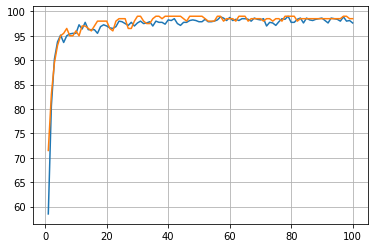

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 101)
plt.plot(x, train_accuracy, x, test_accuracy)

plt.grid(True)
plt.show()

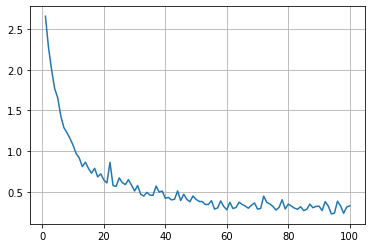

In [ ]:
plt.plot(x, train_loss)
plt.grid(True)
plt.show()

# Show some images classified as faces and non-faces

In [ ]:
# code to get image classified as faces and non faces
model.eval()
model.to('cpu')
loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
batch = next(iter(loader))
images, labels = batch

with torch.no_grad():
  i = 0
  for data in loader:
    if i == 0:
      images, labels = data
      outputs = model(images)
    i+= 1
rounded_outputs = torch.round(outputs.reshape(labels.size(0)))

def print_classified_images(images, outputs):
  positive_face = []
  negative_face = []
  for i in range(len(images)):
    if outputs[i] == 0 :
      positive_face.append(images[i])
    else :
      negative_face.append(images[i])

  grid_p = torchvision.utils.make_grid(positive_face, nrow=5)
  grid_n = torchvision.utils.make_grid(negative_face, nrow=5)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid_p, (1,2,0)))
  plt.imshow(np.transpose(grid_n, (1,2,0)))

print_classified_images(images, rounded_outputs)

# Confusion matrix

Due to a lack of time the confusion matrix was done on a unique training

In [ ]:
model.eval()
model.to('cpu')
loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
batch = next(iter(loader))
images, labels = batch

with torch.no_grad():
  i = 0
  for data in loader:
    if i == 0:
      images, labels = data
      outputs = model(images)
    i+= 1

processed_labels = labels.reshape(labels.size(0))
processed_outputs = torch.round(outputs.reshape(labels.size(0)))

from sklearn import metrics
def confusion_matrix(labels, outputs):
  c_matrix = metrics.confusion_matrix(labels, outputs)
  print(c_matrix)
confusion_matrix(processed_labels, processed_outputs)

[[54  1]
 [ 0 45]]
